In [1]:
from flash_ansr import FlashANSRDataset, get_path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
MODEL = 'v22.0-60M'

In [3]:
dataset = FlashANSRDataset.from_config(get_path('configs', MODEL, 'dataset_val.yaml'))

Compiling Skeletons: 100%|██████████| 1000/1000 [00:00<00:00, 21423.67it/s]


In [4]:
N_SAMPLES = 2**4
print(f'{N_SAMPLES:,}')

16


In [5]:
data_raw = [d for d in dataset.iterate(size=N_SAMPLES, verbose=True, persistent=True, n_per_equation=1, batch_size=1, preprocess=True)]

Generating Batches: 100%|██████████| 16/16 [00:00<00:00, 65.60it/s]


In [6]:
data = {k: [d[k] for d in data_raw] for k in data_raw[0].keys()}

In [7]:
data.keys()

dict_keys(['x_tensors', 'y_tensors', 'data_attn_mask', 'input_ids', 'constants', 'skeleton', 'skeleton_hash', 'expression', 'n_support', 'complexity', 'input_num', 'prompt_mask', 'prompt_metadata'])

In [8]:
for k, v in data.items():
    print(f'{k}:')
    print(f'{v[0][0]}')
    print()

x_tensors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  4.4378,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 11.6963,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.1883,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

y_tensors:
tensor([[4.1800e+02],
        [4.3702e+07],
        [4.2304e-01],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00]])

data_attn_mask:
tensor([ True,  True,  True,  ..., False, False, False])

input_ids:
[1, 7, 11, 13, 12, 14, 84, 15, 14, 36, 84, 15, 14, 30, 71, 31, 84, 76, 15, 14, 31, 84, 76, 15, 14, 58, 71, 15, 14, 29, 30, 71, 31, 84, 76, 58, 71, 15, 14, 76, 15, 14, 71, 15, 14, 82, 15, 16, 31, 84, 76, 17, 18, 36, 83, 19, 18, 31, 74, 41, 65, 74, 19, 8, 9, 62, 56, 30, 84, 49, 29, 36, 84, 41, 31, 76, 29, 30, 71

In [9]:
print(data['skeleton'][2][0])

['/', '-', 'pow1_2', 'x16', '+', 'x16', '+', 'sinh', 'x20', 'x14', '+', 'x20', '/', '+', '*', 'x16', '-', '<constant>', 'x16', '*', 'cos', 'x20', '*', '+', 'x14', 'x16', '-', '/', 'x20', 'x14', 'x16', 'acosh', 'sinh', 'x16']


In [10]:
for term in data['prompt_metadata'][2][0]['allowed_terms']:
    print(term)

['/', 'x20', 'x14']
['-', '<constant>', 'x16']
['-', 'pow1_2', 'x16', '+', 'x16', '+', 'sinh', 'x20', 'x14']
['*', 'cos', 'x20', '*', '+', 'x14', 'x16', '-', '/', 'x20', 'x14', 'x16']
['*', 'x16', '-', '<constant>', 'x16']
['x14']
['+', 'sinh', 'x20', 'x14']
['cos', 'x20']
['x16']
['acosh', 'sinh', 'x16']
['<constant>']
['sinh', 'x20']
['*', '+', 'x14', 'x16', '-', '/', 'x20', 'x14', 'x16']
['-', '/', 'x20', 'x14', 'x16']
['+', 'x16', '+', 'sinh', 'x20', 'x14']
['sinh', 'x16']
['+', 'x14', 'x16']
['pow1_2', 'x16']
['x20']
['x18']


In [8]:
data['skeleton'] = [[str(token) for token in d[0]] for d in data['skeleton']]
data['expression'] = [[str(token) for token in d[0]] for d in data['expression']]
data['constants'] = [[float(constant) for constant in d[0]] for d in data['constants']]
data['n_support'] = np.array([(~(s[0] == 0).all(axis=1)).sum() for s in data['x_tensors']])
data['all_x'] = np.array([x.item() for x_tensor in tqdm(data['x_tensors']) for x in x_tensor.flatten()])
data['all_x'] = data['all_x'][data['all_x'] != 0]
data['all_y'] = np.array([y.item() for y_tensor in tqdm(data['y_tensors']) for y in y_tensor.flatten()])
data['all_constants'] = np.array([c for constants in tqdm(data['constants']) for c in constants])
data['n_constants'] = np.array([len(constants) for constants in data['constants']])
data['n_variables'] = np.array([len([token for token in s if token.startswith('x')]) for s in data['skeleton']])
data['n_unique_variables'] = np.array([len(set([token for token in s if token.startswith('x')])) for s in data['skeleton']])
data['lengths'] = np.array([len(s) for s in data['skeleton']])

100%|██████████| 8192/8192 [00:00<00:00, 7581583.93it/s]


In [9]:
def format_int(x):
    if x < 1_000:
        return int(x)
    elif x < 1_000_000:
        return f'{int(x // 1_000)}k' if x % 1_000 == 0 else f'{x / 1_000:.1f}k'
    else:
        return f'{int(x // 1_000_000)}M' if x % 1_000_000 == 0 else f'{x / 1_000_000:.1f}M'

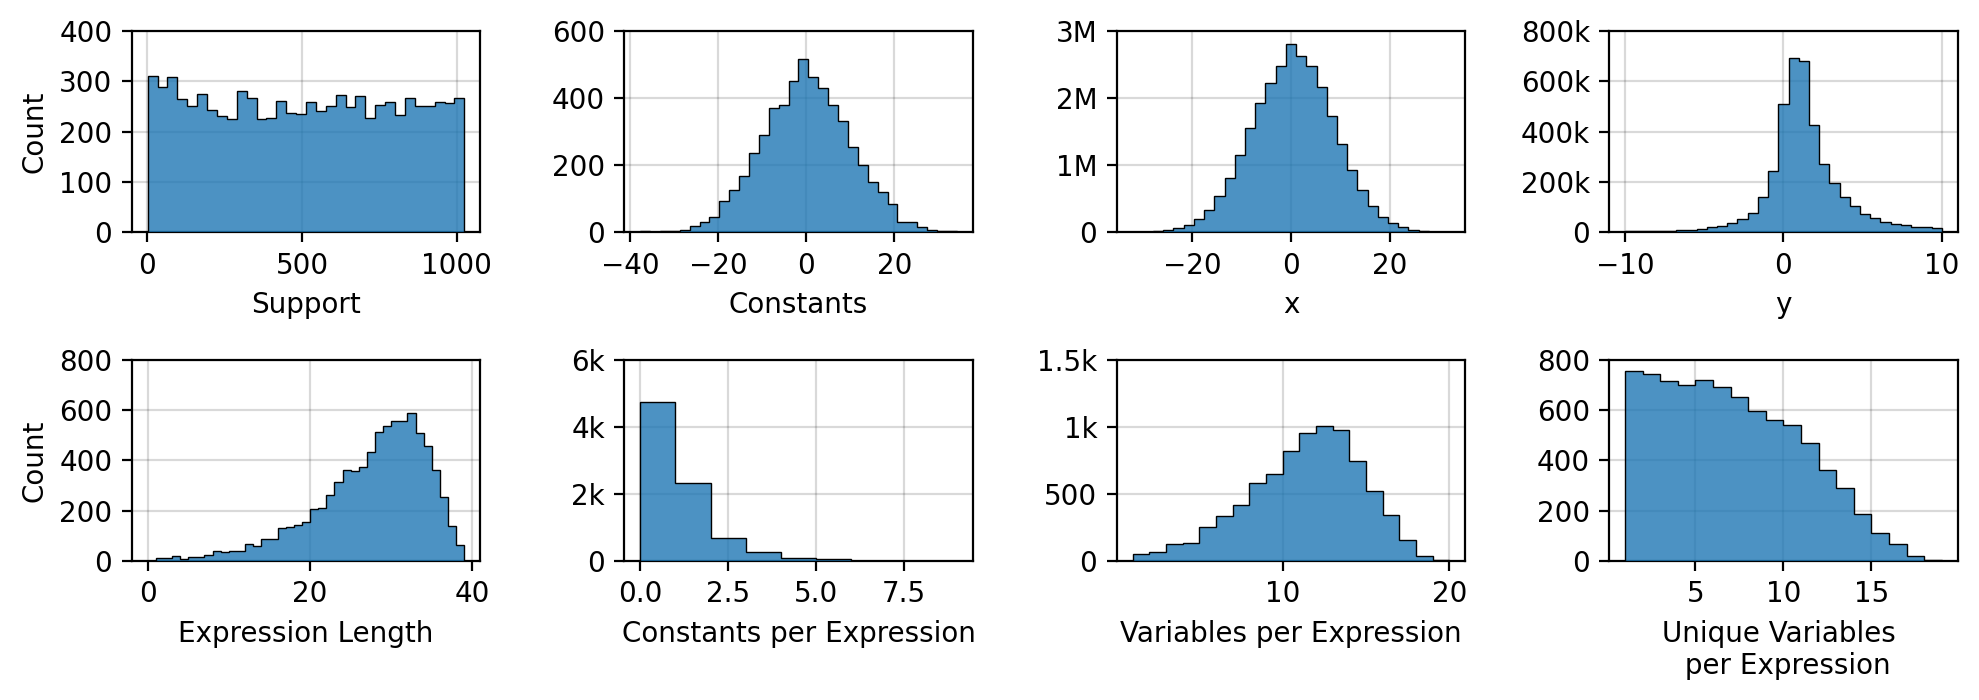

In [10]:
histogram_keys = ['n_support', 'all_constants', 'all_x', 'all_y', 'lengths', 'n_constants', 'n_variables', 'n_unique_variables']
titles = ['Support', 'Constants', 'x', 'y', 'Expression Length', 'Constants per Expression', 'Variables per Expression', 'Unique Variables \n per Expression']
bins_list = [32, 32, np.linspace(-32, 32, 32), np.linspace(-10, 10, 32), np.arange(0, data['lengths'].max()), np.unique(data['n_constants']), np.unique(data['n_variables']), np.unique(data['n_unique_variables'])]

COLS = min(4, len(histogram_keys))
ROWS = np.ceil(len(histogram_keys) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.8), dpi=200)

for i, (ax, k, bins, title) in enumerate(zip(axes.flatten(), histogram_keys, bins_list, titles)):

    d = data[k]
    if k == 'all_y':
        d = np.log10(np.abs(d[d != 0]))

    ax.hist(d, bins=bins, zorder=4, alpha=0.8, rasterized=True)
    ax.hist(d, bins=bins, zorder=6, histtype='step', edgecolor='k', linewidth=0.5, rasterized=True)
    ax.set_xlabel(title)
    if i % COLS == 0:
        ax.set_ylabel('Count')
    ax.grid(alpha=0.15, color='k')
    # ax.set_xticks(np.arange(0, 20, 5));

    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([format_int(y) for y in ax.get_yticks()])

for ax in axes.flatten()[len(histogram_keys):]:
    ax.set_axis_off()

fig.tight_layout(w_pad=2)

# plt.savefig(get_path('results', 'data_analysis', create=True, filename='data_histograms.svg'), bbox_inches='tight')

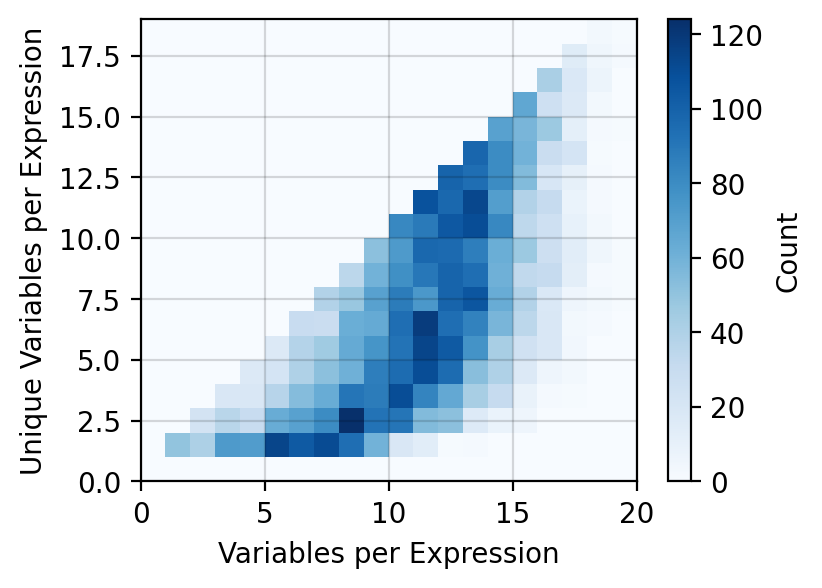

In [11]:
# 2d histogram of the variables per expression vs the unique variables per expression
plt.figure(figsize=(4, 3), dpi=200)
plt.hist2d(data['n_variables'], data['n_unique_variables'], bins=(np.arange(0, data['n_variables'].max()+1), np.arange(0, data['n_unique_variables'].max()+1)), cmap='Blues', rasterized=True)
plt.xlabel('Variables per Expression')
plt.ylabel('Unique Variables per Expression')
plt.colorbar(label='Count')
plt.grid(alpha=0.15, color='k')

In [12]:
data['skeleton'][6]

['log',
 '/',
 '-',
 'div4',
 '+',
 '-',
 'x5',
 'x7',
 '*',
 'x10',
 '*',
 'x18',
 '*',
 'x2',
 '-',
 'x17',
 '<constant>',
 'x3',
 '+',
 'x19',
 '-',
 '/',
 'tanh',
 '/',
 'pow1_5',
 'sin',
 'abs',
 'x18',
 'x8',
 'x13',
 'mult5',
 'x4']

In [13]:
operator_counts = {op: 0 for op in dataset.skeleton_pool.simplipy_engine.operator_arity.keys()}
for skeleton in data['skeleton']:
    for token in skeleton:
        if token in dataset.skeleton_pool.simplipy_engine.operator_arity.keys():
            operator_counts[token] += 1

In [14]:
variable_counts = {v: 0 for v in dataset.skeleton_pool.variables}
for skeleton in data['skeleton']:
    for token in skeleton:
        if token in dataset.skeleton_pool.variables:
            variable_counts[token] += 1
variable_counts

{'x1': 4598,
 'x2': 4490,
 'x3': 4318,
 'x4': 4172,
 'x5': 4394,
 'x6': 4320,
 'x7': 4415,
 'x8': 4531,
 'x9': 4561,
 'x10': 4376,
 'x11': 4403,
 'x12': 4365,
 'x13': 4583,
 'x14': 4327,
 'x15': 4474,
 'x16': 4551,
 'x17': 4462,
 'x18': 4475,
 'x19': 4343,
 'x20': 4452}

In [15]:
operators_total = sum(operator_counts.values())
normalized_operator_counts = {op: count / operators_total for op, count in operator_counts.items()}
normalized_operator_counts_prior = np.array(list(dataset.skeleton_pool.operator_weights.values())) / sum(dataset.skeleton_pool.operator_weights.values())

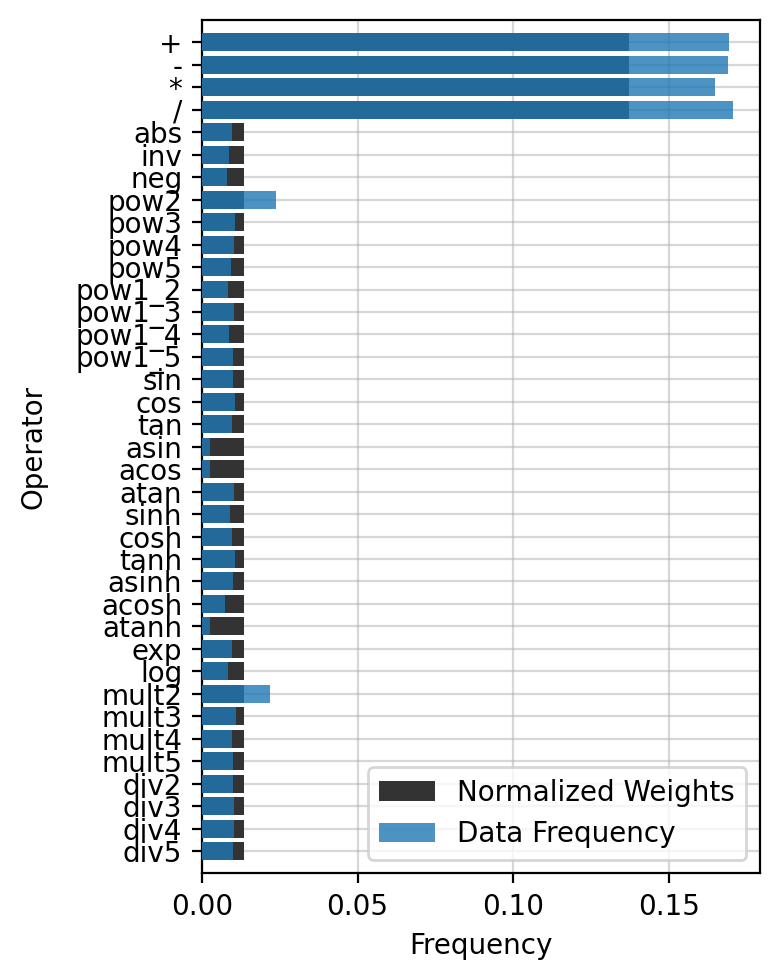

In [16]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=200)

ax.barh(dataset.skeleton_pool.operator_weights.keys(), normalized_operator_counts_prior, zorder=4, color='#333333', label='Normalized Weights', rasterized=True)
ax.barh(dataset.skeleton_pool.operator_weights.keys(), [normalized_operator_counts[op] for op in dataset.skeleton_pool.operator_weights.keys()], zorder=6, alpha=0.8, label='Data Frequency', rasterized=True)

ax.set_ylim(-1, len(dataset.skeleton_pool.operator_weights))

ax.invert_yaxis()

ax.set_xlabel('Frequency')
ax.set_ylabel('Operator', labelpad=10)
ax.grid(alpha=0.5, zorder=1)

ax.legend()

fig.tight_layout()

# plt.savefig(get_path('results', 'data_analysis', create=True, filename='train_operator_frequencies.svg'), bbox_inches='tight')

In [17]:
from collections import Counter

In [18]:
# Most common expressions
counter = Counter([tuple(s) for s in data['skeleton']])

In [19]:
# Note: various permutations of the same expressions may not be present due to filtering of held-out expressions
for expression, count in counter.most_common(32):
    print(f'{count:>3}: {(expression)}')

  3: ('x18',)
  3: ('x16',)
  2: ('x13',)
  1: ('+', 'x17', '/', '/', 'asinh', 'x12', 'x2', '-', 'x8', '/', 'x19', '/', '/', '/', 'x7', 'x13', '-', 'x5', 'x9', '-', 'x20', 'pow5', '-', '*', 'x15', 'x8', 'x3')
  1: ('/', 'pow1_3', 'abs', 'x2', '*', '-', 'x17', 'cos', 'pow1_4', 'x2', '*', '/', 'x2', '*', 'x1', '/', 'mult2', 'x12', 'mult5', 'x12', 'cosh', 'x5')
  1: ('+', 'x19', '+', '-', 'x7', '-', 'div3', 'sin', '+', 'x11', 'pow3', '-', '-', 'pow1_3', '*', 'x19', 'x6', 'mult2', 'x6', 'x15', 'acosh', 'x7', 'x17')
  1: ('atan', '+', 'x16', '+', 'x9', '/', 'asinh', '*', 'x4', 'tanh', '+', 'x18', '+', 'atan', 'x12', '*', 'x15', 'mult5', '+', 'x10', 'x18', 'div3', 'x15')
  1: ('/', '-', 'x10', '-', '+', 'x1', 'x14', '+', 'mult2', 'x7', '-', 'pow1_3', 'x16', 'x12', '*', 'x4', '-', '-', 'x7', '*', 'x14', 'x4', '/', '-', 'x12', '*', 'x1', 'x3', 'x10')
  1: ('acosh', '-', 'sin', '/', 'x12', 'mult3', '-', '/', 'x15', 'div5', 'asinh', 'asinh', '/', 'x12', 'x15', 'pow4', '/', 'x12', 'x15', 'pow1_3'

In [20]:
one_dimensional_x = np.array([np.array(x_tensor)[0] for x_tensor, n_unique_variables in zip(data['x_tensors'], data['n_unique_variables']) if n_unique_variables == 1])
one_dimensional_x = np.array([x[:, np.where((~(x == 0).all(axis=0)))[0][0]].flatten() for x in one_dimensional_x])

one_dimensional_y = np.array([np.array(y_tensor).flatten() for y_tensor, n_unique_variables in zip(data['y_tensors'], data['n_unique_variables']) if n_unique_variables == 1])

print(one_dimensional_x.shape, one_dimensional_y.shape)

one_dimensional_x = np.concatenate(one_dimensional_x)
one_dimensional_y = np.concatenate(one_dimensional_y)

print(one_dimensional_x.shape, one_dimensional_y.shape)

(755, 1024) (755, 1024)
(773120,) (773120,)


/tmp/ipykernel_17532/3825786293.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  one_dimensional_x = np.array([np.array(x_tensor)[0] for x_tensor, n_unique_variables in zip(data['x_tensors'], data['n_unique_variables']) if n_unique_variables == 1])
/tmp/ipykernel_17532/3825786293.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  one_dimensional_y = np.array([np.array(y_tensor).flatten() for y_tensor, n_unique_variables in zip(data['y_tensors'], data['n_unique_variables

In [21]:
from matplotlib.colors import LogNorm

In [22]:
tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.5) + (1.0,)

(np.float64(0.133502), np.float64(0.002437), np.float64(0.1647075), 1.0)

In [23]:
one_dimensional_x.shape,one_dimensional_y.shape

((773120,), (773120,))

/tmp/ipykernel_17532/3258403792.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


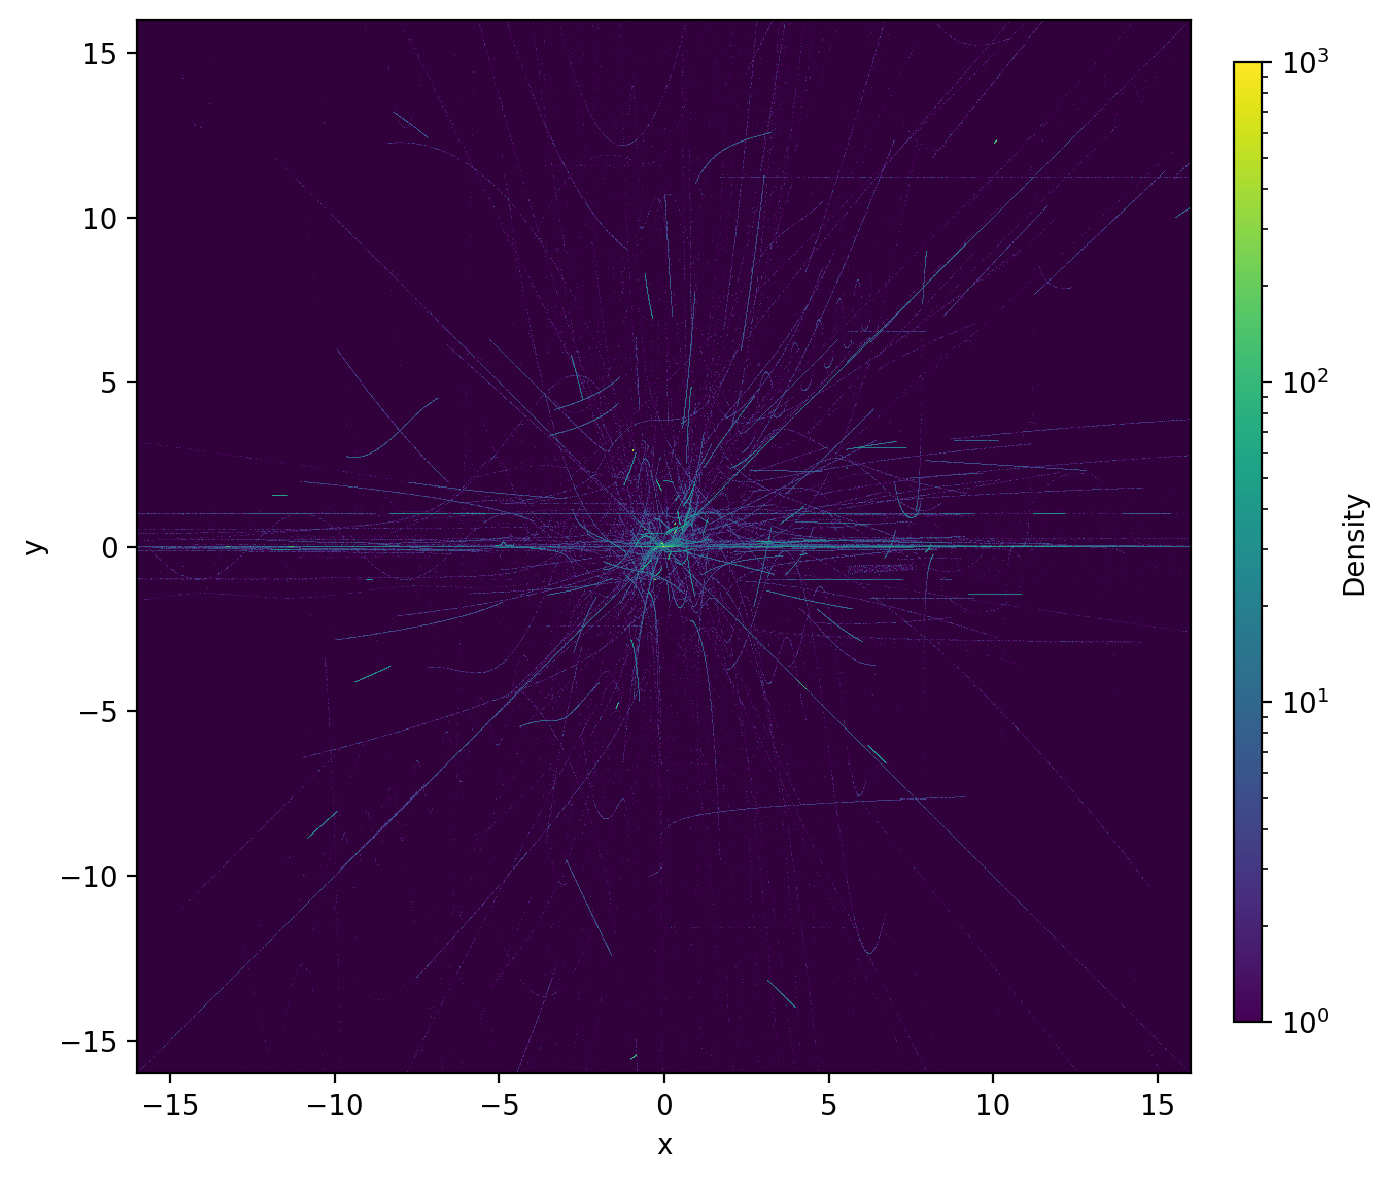

In [24]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=200)

# Change the fontsize
plt.rcParams.update({'font.size': 10})

res = 512
lim = 16
img = ax.hist2d(one_dimensional_x, one_dimensional_y, bins=(np.linspace(-lim, lim, res*2), np.linspace(-lim, lim, res*2)), norm=LogNorm(vmin=1, vmax=1e3), rasterized=True);
ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.7) + (1,))

ax.set_aspect('equal')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.80])
fig.colorbar(img[3], cax=cbar_ax, label='Density')

fig.tight_layout()

# plt.savefig(get_path('results', 'data_analysis', create=True, filename='1d_train_superimposed.svg'), bbox_inches='tight')